<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/FinalLstmGru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Conv2D,ConvLSTM2D,BatchNormalization,Conv3D, Conv1D, GlobalAveragePooling2D, GRU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate,Reshape
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
#from test_utils import summary, comparator
import seaborn as sns
warnings.filterwarnings('ignore')

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/FV_all_in_one.csv'
df = pd.read_csv(path)
df = df.drop(df.columns[[0]], axis=1)

In [ ]:
path1 = '/content/gdrive/MyDrive/Data_Set/predicted100x100.csv'
predicted = pd.read_csv(path1)
predicted = predicted.drop(predicted.columns[[0]], axis=1)
predicted = predicted.to_numpy()
predicted = predicted.reshape((-1,100,100))
predicted.shape

(8640, 100, 100)

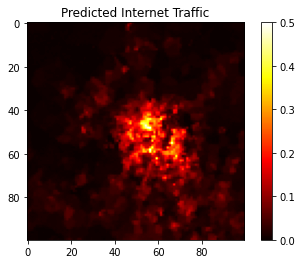

In [ ]:
import matplotlib.pyplot as plt
Z2 = predicted[7185,:,:]
plt.imshow(Z2,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.5)
plt.colorbar()
plt.show()

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'] , unit="s")
#df.set_index(df['Datetime'] ,inplace=True)
#df = df.drop(df.columns[[0]], axis=1)
#df.head()
dfdata = df.iloc[:,1:10001].to_numpy()
print(dfdata.shape)
arr3d = dfdata.reshape(8928, 100, 100)
shapeData = arr3d.shape
print(shapeData)

(8928, 10000)
(8928, 100, 100)


In [ ]:
def shapingInputs( arr3d , predicted , cx , cy , numInps ):
  shapeData = arr3d.shape
  X = np.zeros(( shapeData[0]-numInps , numInps+1))
  Y = arr3d[numInps : , cx , cy]
  Y = Y.reshape((-1,1))

  for i in range(0,shapeData[0]-numInps):
    X[i,1:] = arr3d[i:i+numInps , cx , cy]/2000
    X[i,0] = predicted[i, cx , cy]

  return X , Y/2000

In [ ]:
# for i in [[12,47], [23,39], [29,35], [31,37] , [35,79] , [41,41] , [42,68], [46,78] , [52,80], [60,78], [62,54], [72,39], [75,24], [81,83],  [86,72],  [90,75],  [92,52], [92,97], [98,51]]:
#   print(i[0])
#   numInps = 5
#   length = 144*15
#   st = 0 # start 
#   w  = 100 # width
#   X ,Y = shapingInputs( arr3d[8:length+13,st:st+w,st:st+w] ,predicted[:length],i[0],i[1], numInps )
#   model.fit(X[:144*15], Y[:144*15], epochs =2 , batch_size = 16, validation_split=0.2)

#   start = 144*12
#   le = 144*16
#   valPredict = model.predict(X[start:start+le])
#   valPredict = valPredict.reshape((-1,1))
#   yout = Y[start : start + valPredict.shape[0]]

#   Z1 = yout
#   Z2 = valPredict
#   print('Absolute percentage error is = ' , absErrorOne(Z1 , Z2))
#   print('Absolute percentage mse is = ' , msepOne(Z1 , Z2))
#   print('Percentage rmse is = ' , (msepOne(Z1 , Z2))**0.5)


In [ ]:
numInps = 5
length = 144*20
st = 0 # start 
w  = 100 # width
X ,Y = shapingInputs( arr3d[8:length+13,st:st+w,st:st+w] ,predicted[:length],49,42, numInps )
print('X.shape : ',X.shape)
print('Y.shape : ',Y.shape)
#Y1 = Y.reshape(-1, w, w,1)
#print('Y1.shape : ',Y1.shape)

X.shape :  (2880, 6)
Y.shape :  (2880, 1)


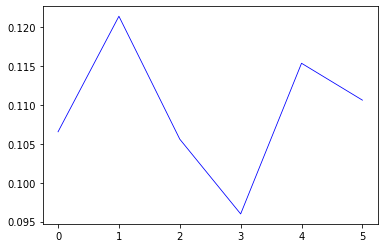

In [ ]:
#plt.plot( X[3323],color = 'blue', linewidth=0.8)

In [ ]:
# # Make sure images have shape (28, 28, 1)
# x_train = X.transpose((0,2,3,1))
# #x_test = np.expand_dims(x_test, -1)
# print("x_train shape:", x_train.shape)
# print(x_train.shape[0], "train samples")
# #print(x_test.shape[0], "test samples")


## Model

**Keras: Multiple Inputs and Mixed Data**

```
# # define two sets of inputs
  inputA = Input(shape=(32,))
  inputB = Input(shape=(128,))
  # the first branch operates on the first input
  x = Dense(8, activation="relu")(inputA)
  x = Dense(4, activation="relu")(x)
  x = Model(inputs=inputA, outputs=x)
  # the second branch opreates on the second input
  y = Dense(64, activation="relu")(inputB)
  y = Dense(32, activation="relu")(y)
  y = Dense(4, activation="relu")(y)
  y = Model(inputs=inputB, outputs=y)
  # combine the output of the two branches
  combined = concatenate([x.output, y.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = Dense(2, activation="relu")(combined)
  z = Dense(1, activation="linear")(z)
  # our model will accept the inputs of the two branches and
  # then output a single value

model = Model(inputs=[x.input, y.input], outputs=z)
```



In [ ]:
def finalModel(input_shape=(6)):
   
    # create the input layer (Same as the imageNetv2 input size)
    inputs = Input(shape=input_shape) 
    x = inputs
    x = Reshape((1,-1))(x)
    x = LSTM(128)(x)
    x = RepeatVector(128)(x)
    x = Dense(1024,activation='relu')(x)
    x = TimeDistributed(Dense(1024))(x)
    x = Dropout(rate=0.2)(x)
    x = LSTM(512 )(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(1, activation='relu')(x)



    # #x =  tfl.LSTM(20,activation='relu',return_sequences=True)(x)
    # x =  Dense(512,activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = GRU(units=1024,return_sequences=True,go_backwards=True,unroll=True)(x)
    # x = Dense(units=10000, activation='relu')(x)
    # x =  Reshape((100,100))(x)

    ### END CODE HERE
    
    model = tf.keras.Model(inputs, x)
    
    return model

In [ ]:
num_channels = 6

model = finalModel((num_channels))

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 6)]               0         
                                                                 
 reshape_18 (Reshape)        (None, 1, 6)              0         
                                                                 
 lstm_37 (LSTM)              (None, 128)               69120     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 128, 128)         0         
 or)                                                             
                                                                 
 dense_29 (Dense)            (None, 128, 1024)         132096    
                                                                 
 time_distributed_14 (TimeDi  (None, 128, 1024)        1049600   
 stributed)                                               

## Train

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=["MeanSquaredError"])

In [ ]:
model.optimizer="adam"

130/130 [==============================] - 396s 3s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean_squared_error: 0.0011


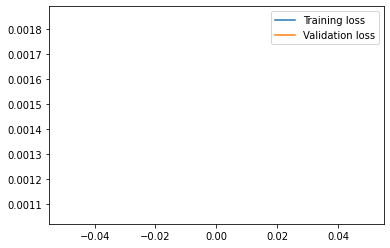

In [ ]:
history = model.fit(X[144*13*0:144*18], Y[144*13*0:144*18], epochs =1 , batch_size = 16, validation_split=0.2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#model.save('/content/gdrive/MyDrive/Data_Set/FinalLstmGru_0221_08.model')#07 maru
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Set/FinalLstmGru_0221_07.model")

In [ ]:
# trainPredict = model.predict(x_train[3200:4000])
# trainPredict = trainPredict.reshape(-1,1)
# print(trainPredict.shape)

In [ ]:
start = 144*13
le = 144*5
valPredict = model.predict(X[start:start+le])
valPredict = valPredict.reshape((-1,1))
yout = Y[start : start + valPredict.shape[0]]
print('pred shape = ',valPredict.shape)
print('yout shape = ',yout.shape)

23/23 [==============================] - 16s 693ms/step
pred shape =  (720, 1)
yout shape =  (720, 1)


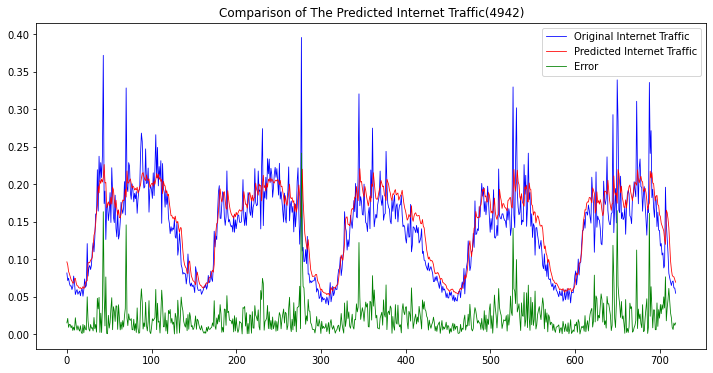

In [ ]:

fig = plt.figure(figsize=(12, 6))
Z1 = yout
plt.plot( Z1,color = 'blue', linewidth=0.8)
#plt.title("Original Internet Traffic")

Z2 = valPredict
plt.plot(Z2,color = 'red', linewidth=0.8)
#plt.title("Predicted Internet Traffic")

Z3 = abs(Z2-Z1)
plt.plot( Z3,color = 'green', linewidth=0.8)
plt.title("Comparison of The Predicted Internet Traffic(4942)")
plt.legend(["Original Internet Traffic","Predicted Internet Traffic","Error"])
plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/FinalGRU_4942.png',transparent=True)
plt.show()


In [ ]:
print(Z3.max())
print(Z3.min())
print('pred shape = ',valPredict.shape)

0.04180320617443398
2.744452481502624e-06
pred shape =  (720, 1)


In [ ]:
def absError(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)


def msep(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/(ypred.shape[1] * ypred.shape[2])/ypred.shape[0]
  return np.sum(dif)

def absErrorOne(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/ypred.shape[0]
  return np.sum(dif)


def msepOne(y , ypred):
  i = 2
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.square(ypred - y) , np.square(y) ))/ypred.shape[0]
  return np.sum(dif)

In [ ]:
print('Absolute percentage error is = ' , absErrorOne(Z1 , Z2))
print('Absolute percentage mse is = ' , msepOne(Z1 , Z2))
print('Percentage rmse is = ' , (msepOne(Z1 , Z2))**0.5)

Absolute percentage error is =  0.16574367499136966
Absolute percentage mse is =  0.04443047215917288
Percentage rmse is =  0.21078536988883476
